In [1]:
import sys
sys.path.append('..')

In [2]:
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from core.dataset import *
from core.utils import *

In [3]:
path = 'D:/Data/hoffmanlab/featureselection/data/'

In [13]:
ligands = ['CpG_am', 'FLA_am', 'FSL_am', 'LPS_am', 'P3K_am', 'PIC_am', 'R84_am', 'TNF_am']
polarizations = ['', 'i0', 'i3', 'i4', 'ib', 'ig']

In [14]:
data = PolarData(path, ligands, polarizations, merge=True)

## Performance threshold analysis using features derived from models fit on individual ligands

In [20]:
cpg_tf = ['envelope_5', 'integrals_pos_83', 'integrals_57']
fla_tf = ['integrals_pos_64', 'duration_3', 'integrals_pos_15']
fsl_tf = ['integrals_pos_15', 'integrals_pos_13', 'integrals_pos_19']
lps_tf = ['power_119', 'envelope_5', 'integrals_pos_39']
p3k_tf = ['duration_4', 'median_peak_amp', 'integrals_pos_35']
pic_tf = ['integrals_pos_40', 'integrals_pos_33', 'integrals_pos_47']
r84_tf = ['integrals_pos_24', 'integrals_pos_88', 'peak2rms']
tnf_tf = ['mean_movvar', 'time_series_3', 'std_peak2trough']

In [21]:
all_tf = cpg_tf + fla_tf + fsl_tf + lps_tf + p3k_tf + pic_tf + r84_tf + tnf_tf

In [22]:
all_tf = list(set(all_tf))

## Iterative popping

In [23]:
import sklearn
from sklearn import preprocessing
from sklearn import metrics
from sklearn import model_selection

In [29]:
epochs = 20
labels = data.iloc[:, [984]].to_numpy().reshape(-1, )
n = len(all_tf)
crs = []
static_percent_res = []
seq_percent_res = []

In [32]:
for e in range(epochs):
    d = all_tf[:(n-e)] 
    print(f'\nNumber of features: {n - e}')
    cr = one_fit(d, data, polarizations, random_state=100, verbose=True, ret=True)
    
    if e != 0: 
        static_residual = cr.iloc[8, 2] / crs[0].iloc[8, 2]
        percent_residual = cr.iloc[8, 2] / crs[-1].iloc[8, 2]
        
        print(f'Static Percentange Residual {static_residual}')
        print(f'Sequential Percentage Residual: {percent_residual}')
        
        static_percent_res.append(static_residual)
        seq_percent_res.append(percent_residual)
        
    crs.append(cr)


Number of features: 22
[13:43:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score     support
               0.339058  0.432509  0.380124  1415.00000
i0             0.327848  0.226597  0.267977  1143.00000
i3             0.320513  0.293830  0.306592  1021.00000
i4             0.411765  0.429354  0.420375   913.00000
ib             0.396954  0.387129  0.391980  1010.00000
ig             0.428251  0.439417  0.433762  1304.00000
accuracy       0.371290  0.371290  0.371290     0.37129
macro avg      0.370732  0.368139  0.366802  6806.00000
weighted avg   0.369827  0.371290  0.367695  6806.00000

Number of features: 21
[13:43:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/

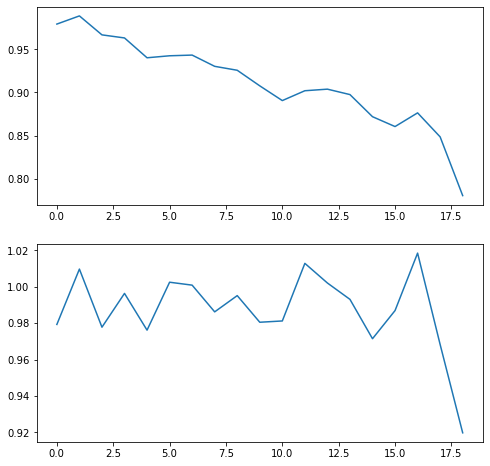

In [34]:
fig, ax = plt.subplots(2, figsize=(8, 8))

ax[0].plot(static_percent_res)
ax[1].plot(seq_percent_res)

# 90% residual ~ 12  features

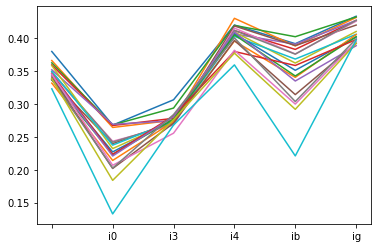

In [46]:
for i in crs:
    i['f1-score'][:6].plot()

## Iterative breadth-first pop

In [88]:
import itertools

In [89]:
epochs = 20
labels = data.iloc[:, [984]].to_numpy().reshape(-1, )
n = len(all_tf)
crs = []
static_percent_res = []
seq_percent_res = []

In [90]:
# rerun this cell to reset pops in all_tf_list
cpg_tf = ['envelope_5', 'integrals_pos_83', 'integrals_57']
fla_tf = ['integrals_pos_64', 'duration_3', 'integrals_pos_15']
fsl_tf = ['integrals_pos_15', 'integrals_pos_13', 'integrals_pos_19']
lps_tf = ['power_119', 'envelope_5', 'integrals_pos_39']
p3k_tf = ['duration_4', 'median_peak_amp', 'integrals_pos_35']
pic_tf = ['integrals_pos_40', 'integrals_pos_33', 'integrals_pos_47']
r84_tf = ['integrals_pos_24', 'integrals_pos_88', 'peak2rms']
tnf_tf = ['mean_movvar', 'time_series_3', 'std_peak2trough']

In [91]:
all_tf_list = [cpg_tf, fla_tf, fsl_tf, lps_tf, p3k_tf, pic_tf, r84_tf, tnf_tf]

In [92]:
r = 0
for e in range(3):
    for i in all_tf_list:
        i.pop() # pop least important feature
            
        d = list(itertools.chain(*all_tf_list))
        
        if len(d) == 0:
            break
            
        print(f'\nNumber of features: {len(d)}') # make sure this is working correctly
        
        cr = one_fit(d, data, polarizations, random_state=100, verbose=True, ret=True)
        
        if r != 0:
            static_residual = cr.iloc[8, 2] / crs[0].iloc[8, 2]
            percent_residual = cr.iloc[8, 2] / crs[-1].iloc[8, 2]
        
            print(f'Static Percentange Residual {static_residual}')
            print(f'Sequential Percentage Residual: {percent_residual}')

            static_percent_res.append(static_residual)
            seq_percent_res.append(percent_residual)
        
        r += 1
        
        crs.append(cr)


Number of features: 23
[14:03:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score      support
               0.325979  0.417668  0.366171  1415.000000
i0             0.317839  0.221347  0.260959  1143.000000
i3             0.320755  0.299706  0.309873  1021.000000
i4             0.415433  0.430449  0.422808   913.000000
ib             0.397762  0.387129  0.392373  1010.000000
ig             0.436834  0.440184  0.438503  1304.000000
accuracy       0.368498  0.368498  0.368498     0.368498
macro avg      0.369100  0.366081  0.365115  6806.000000
weighted avg   0.367720  0.368498  0.365401  6806.000000

Number of features: 22
[14:03:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rele

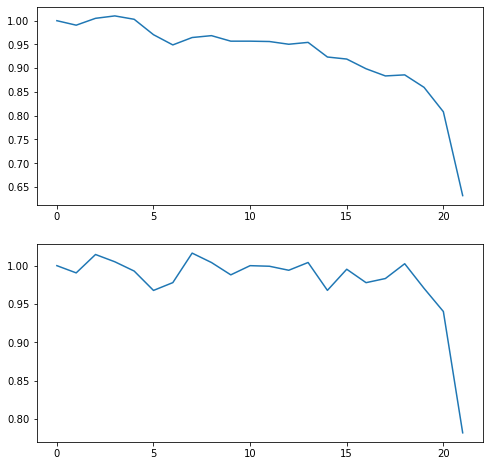

In [93]:
fig2, ax2 = plt.subplots(2, figsize=(8,8))

ax2[0].plot(static_percent_res)
ax2[1].plot(seq_percent_res)

# threshold ~ 7 features

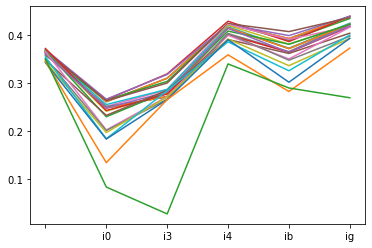

In [94]:
for i in crs:
    i['f1-score'][:6].plot()